# AUC を実装する

---

## 実装してみる

### 必要なパッケージを読み込む

In [1]:
library(rpart)
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### 真陽性率と偽陽性率を計算する

In [2]:
calc_pr <-
  function(data) {
    # 実測値と予測値をひとつのデータフレームへ結合する
    data %>%
    # 予測値ごとに TP の数と FP の数をカウントする
    group_by(predicted) %>%
    summarise(
      n.y.p = sum(y == 1),
      n.y.n = sum(y == 0)
    ) %>%
    ungroup() %>%
    # 予測値で降順にソートする
    arrange(desc(predicted)) %>%
    # 真陽性率と偽陽性率を計算する
    mutate(
      tpr = cumsum(n.y.p) / sum(n.y.p),
      fpr = cumsum(n.y.n) / sum(n.y.n)
    ) %>%
    add_row(predicted = Inf, tpr = 0.0, fpr = 0.0) %>%
    add_row(predicted = -Inf, tpr = 1.0, fpr = 1.0) %>%
    # 行を追加したので、改めて予測値で降順にソートする
    arrange(desc(predicted))
  }

### AUC を計算する

In [3]:
calc_auc <-
  function(data) {
    # ROC 曲線上の隣り合う点のペアを1レコードにする
    inner_join(
      data %>% mutate(i = 1:n()),
      data %>% mutate(i = 1:n() - 1),
      by = "i"
    ) %>%
    # ROC 曲線上の隣り合う点と x 軸の間にある台形の面積を求める
    mutate(auc = (tpr.y + tpr.x) * (fpr.y - fpr.x) / 2) %>%
    # 台形の面積を足し合わせる
    summarise(auc = sum(auc)) %>%
    .$auc
  }

---

## 実際に指標を計算してみる

### サンプルデータを生成する

In [4]:
# 再現性確保のため、乱数のシードを固定する
set.seed(0)

# サンプルデータを生成する
data <-
  bind_rows(
    # 負例を生成する
    tibble(
      y = 0,
      x1 = rnorm(n = 1000, mean = -1, sd = 1),
      x2 = rnorm(n = 1000, mean = -1, sd = 1)
    ),
    # 正例を生成する
    tibble(
      y = 1,
      x1 = rnorm(n = 100, mean = 1, sd = 1),
      x2 = rnorm(n = 100, mean = 1, sd = 1)
    )
  )

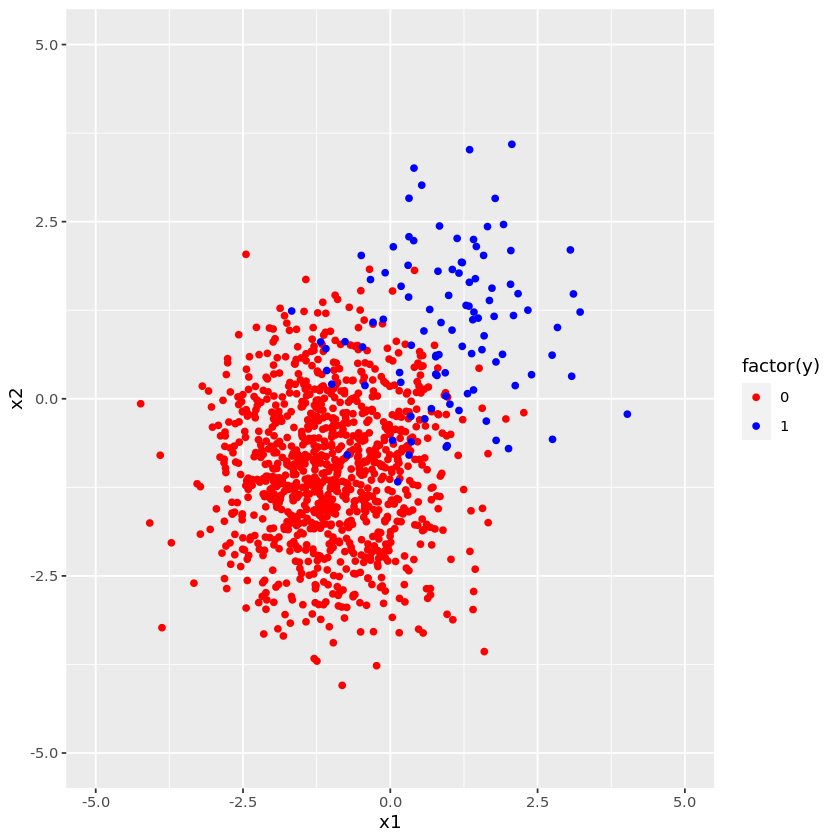

In [5]:
# サンプルデータを可視化する
graph <-
  ggplot(data = data, mapping = aes(x = x1, y = x2, color = factor(y))) +
  geom_point() +
  xlim(-5, 5) +
  ylim(-5, 5) +
  scale_color_manual(values = c("red", "blue"))
plot(graph)

### モデルを作成する

In [6]:
# 決定木で x1 と x2 から y を予測するモデルを作成する
model <- rpart(formula = y ~ ., data = data, method = "class")

In [7]:
# 予測結果を得る
data$predicted <- predict(model, data)[, 2]

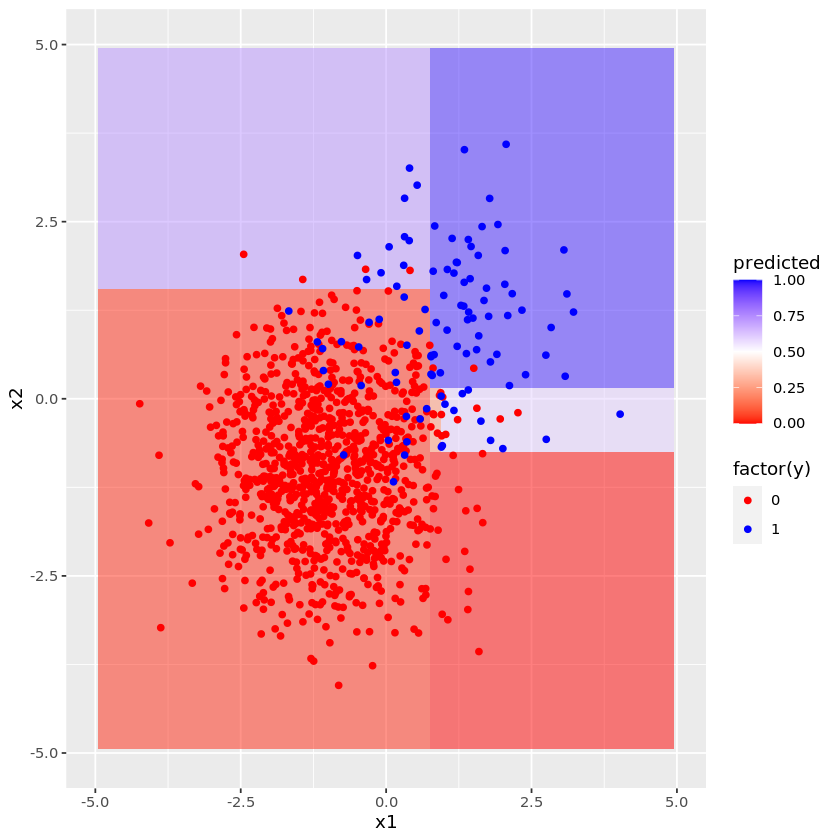

In [8]:
# モデルを可視化する
grid <- expand.grid(x1 = seq(-5, 5, 0.1), x2 = seq(-5, 5, 0.1))
grid$predicted <- predict(model, grid)[, 2]
graph <-
  ggplot() +
  geom_tile(data = grid, mapping = aes(x = x1, y = x2, fill = predicted), alpha = 0.5) +
  geom_point(data = data, mapping = aes(x = x1, y = x2, color = factor(y))) +
  xlim(-5, 5) +
  ylim(-5, 5) +
  scale_color_manual(values = c("red", "blue")) +
  scale_fill_gradient2(low = "red", mid = "white", high = "blue", limits = c(0, 1), midpoint = 0.5)
plot(graph)

### 真陽性率と偽陽性率を計算する

In [9]:
temp <- calc_pr(data)
temp

predicted,n.y.p,n.y.n,tpr,fpr
<dbl>,<int>,<int>,<dbl>,<dbl>
Inf,NA,NA,0.00,0.000
0.96428571,54,2,0.54,0.002
0.73333333,11,4,0.65,0.006
0.60000000,9,6,0.74,0.012
0.22222222,2,7,0.76,0.019
0.02436548,24,961,1.00,0.980
0.00000000,0,20,1.00,1.000
-Inf,NA,NA,1.00,1.000


### ROC 曲線を描く

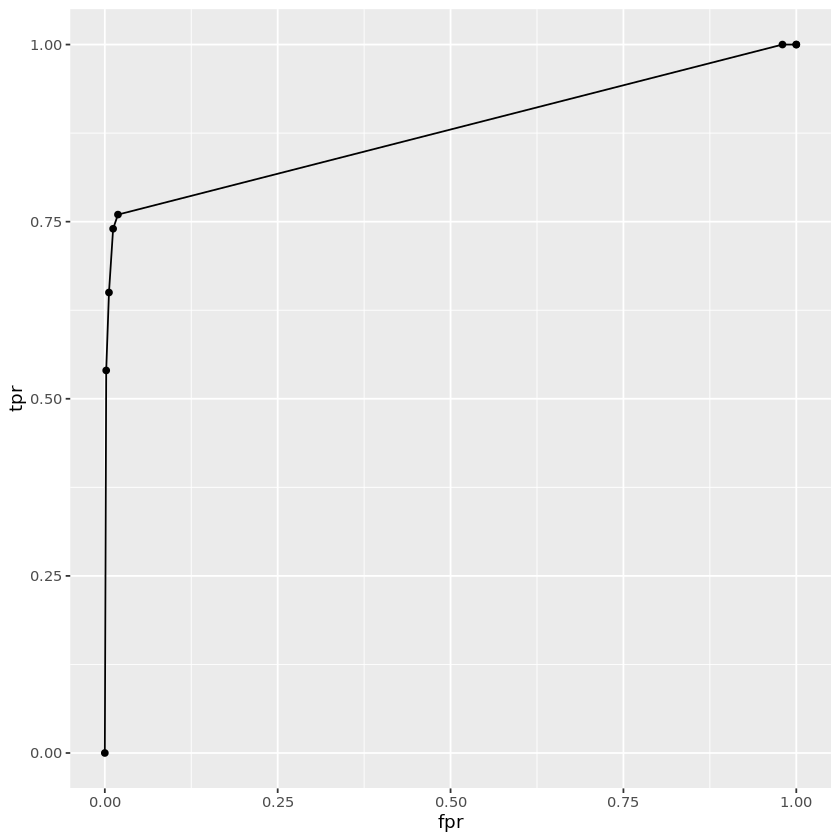

In [10]:
graph <-
  ggplot(data = temp, mapping = aes(x = fpr, y = tpr)) +
  geom_line() +
  geom_point()
plot(graph)

### AUC を計算する

In [11]:
calc_auc(temp)

[1] 0.87802

---

## 動作環境

In [12]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.8.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.4     purrr_0.3.4    
 [5] readr_1.4.0     tidyr_1.1.2     tibble_3.0.6    ggplot2_3.3.3  
 [9] tidyverse_1.3.0 rpart_4.1-13   

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      tidyselect_1.1.0  repr_1.1.3        haven_2.3.1      
 [5] colorspace_2.0-0 